In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json

import cv2 as cv

from skimage import morphology as mo
from skimage.filters import sobel

import networkx as nx

from rdp import rdp

In [2]:
class Node:
    def __init__(self, x, y, color, endpoint=False):
        self.x = x
        self.y = y
        self.color = color
        self.endpoint = endpoint

In [3]:
G = nx.Graph()

In [4]:
images = [plt.imread(image_path) for image_path in ["data/groundtruth/{}_gt.pgm".format(i) for i in range(1, 21)]]

### Esqueletización

In [5]:
def skeletonize(image):
    return mo.skeletonize(image)

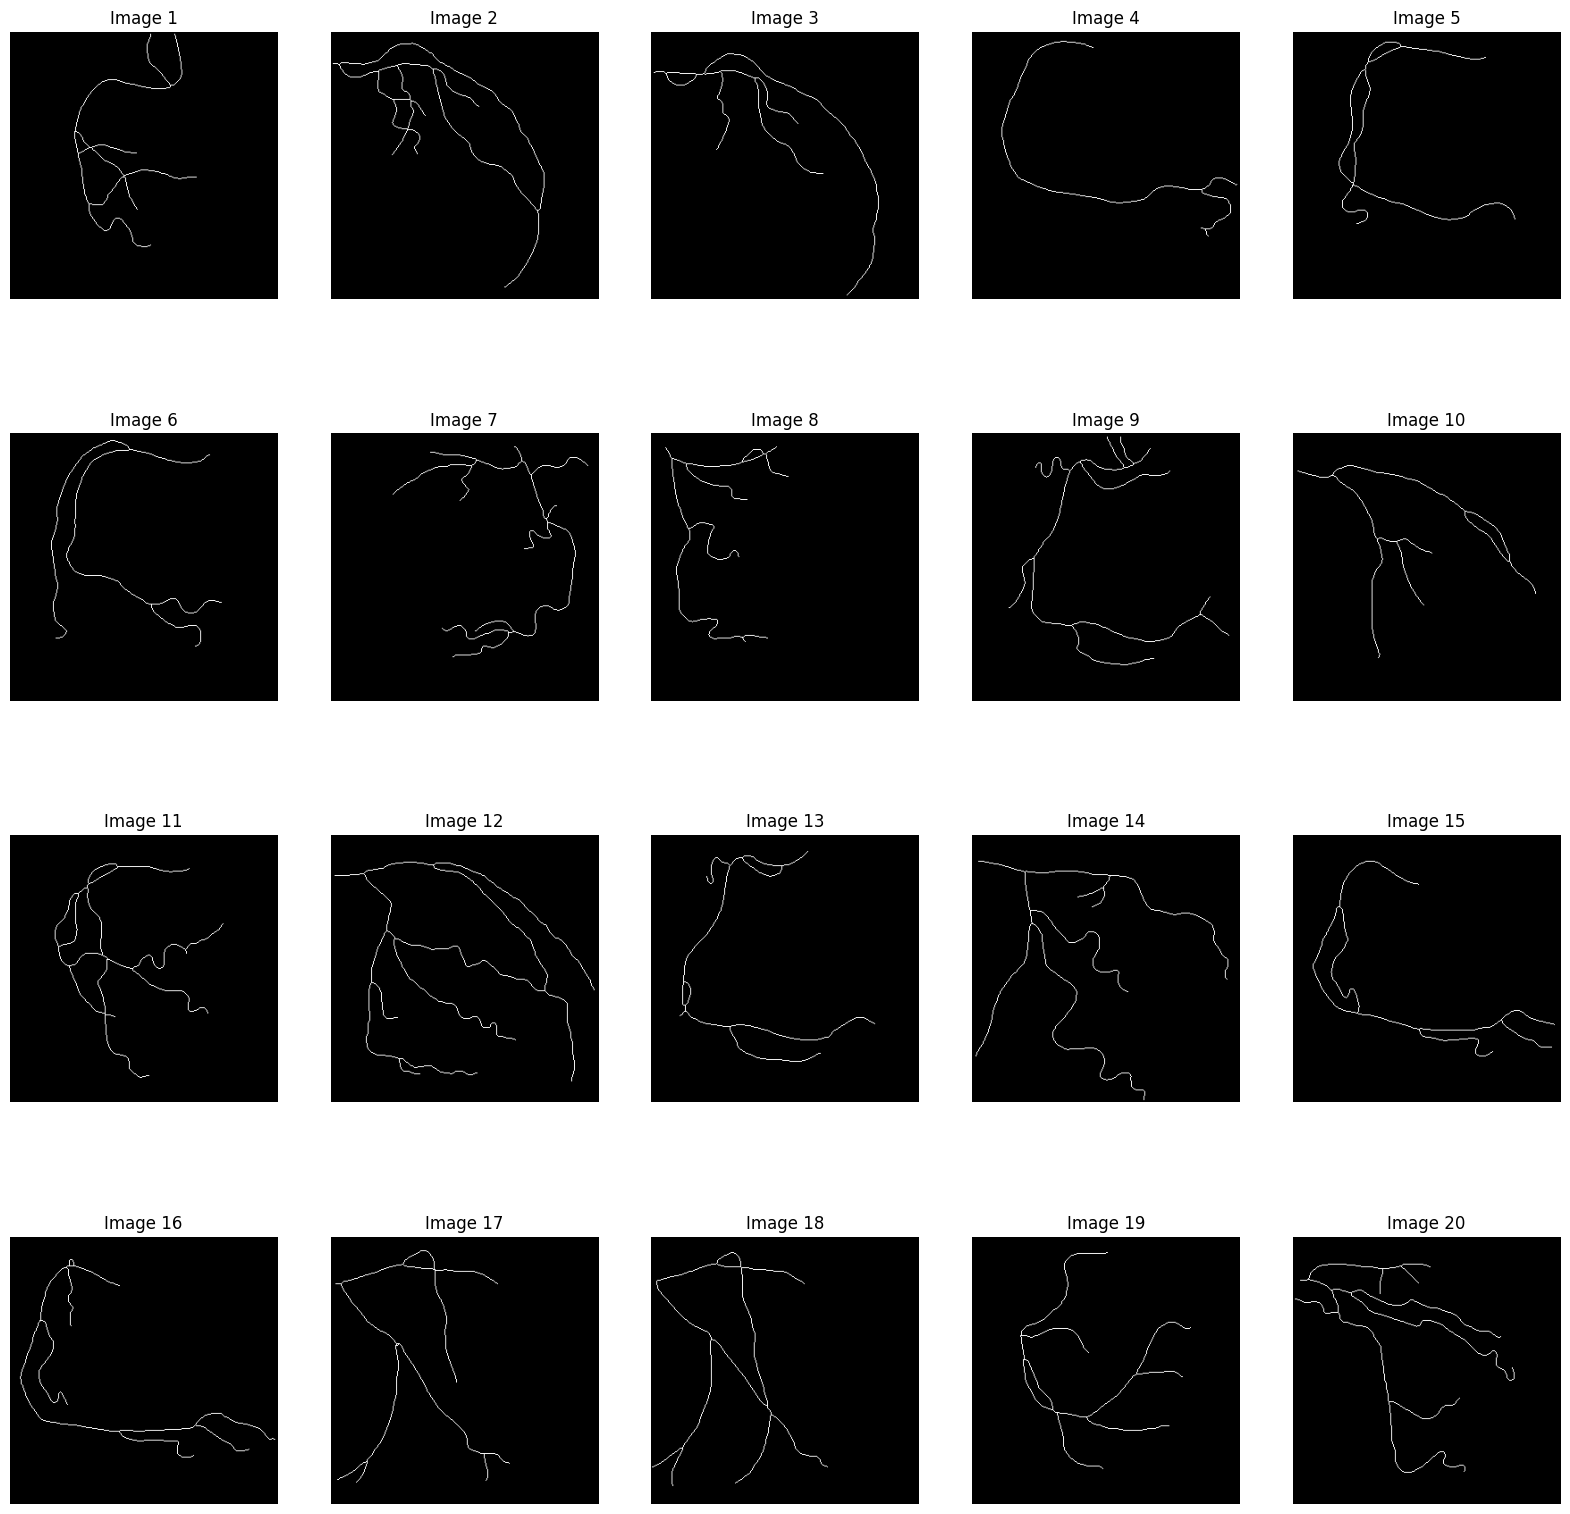

In [6]:
plt.figure(figsize=(20, 20))
for i, image in enumerate(images):
    skeleton = skeletonize(image)
    
    plt.subplot(4, 5, i + 1)
    plt.imshow(skeleton, cmap="gray")
    plt.title("Image {}".format(i + 1))
    plt.axis("off")

### Nodos

In [7]:
def get_transitions(image, x, y):
    # Obtener cuantos pixeles vecinos son 0 y cuantos son 1
    neighbors = [
        image[x-1, y], image[x-1, y+1], image[x, y+1], image[x+1, y+1],
        image[x+1, y], image[x+1, y-1], image[x, y-1], image[x-1, y-1]
    ]
    
    neighbors = [1 if n > 0 else 0 for n in neighbors]

    transitions = sum((neighbors[i] == 0 and neighbors[i+1] == 1) for i in range(len(neighbors) - 1))
    transitions += (neighbors[-1] == 0 and neighbors[0] == 1)

    return transitions

In [8]:
def simplify_borders(borders):
    # Simplificar los bordes de las imagenes usando el algoritmo de Ramer-Douglas-Peucker
    simplified_borders = []
    
    border_coords = [(i, j) for i in range(1, borders.shape[0] - 1) for j in range(1, borders.shape[1] - 1) if borders[i, j]]
    
    for i in range(0, len(border_coords), 50):
        segment = border_coords[i:i + 50]
        simplified_borders.extend(rdp(segment, epsilon=100))
        
    return simplified_borders

In [9]:
def create_intermediate_nodes(image, nodes):
    # Crea una lista de nodos intermedios para los bordes horizontales, verticales y generales
    # Para obtener los bordes se aplica un filtro de Sobel
    # Se aplica RDP para simplificar los bordes y crear nodos intermedios en los segmentos
    
    nodes_list = []
    
    # Sobel
    sobel_x = sobel(image, axis=0)
    sobel_y = sobel(image, axis=1)
    
    borders_x = sobel_x > np.mean(sobel_x)
    borders_y = sobel_y > np.mean(sobel_y)
    borders = np.sqrt(sobel_x**2 + sobel_y**2)

    # RDP
    simplified_borders_x = simplify_borders(borders_x)    
    simplified_borders_y = simplify_borders(borders_y)
    simplified_borders = simplify_borders(borders)

    # Crear nodos intermedios
    for node in simplified_borders_x + simplified_borders_y + simplified_borders:
        if image[node[0], node[1]] == 0:
            found = False
            for n in nodes:
                if abs(n.x - node[0]) < 3 and abs(n.y - node[1]) < 3:
                    found = True
                    break
            if not found:
                nodes_list.append(Node(node[0], node[1], (128, 128, 128)))
                
    # Eliminar nodos duplicados o muy cercanos
    for node in nodes_list:
        found = False
        for n in nodes_list:
            if n != node and abs(n.x - node.x) < 1 and abs(n.y - node.y) < 1:
                found = True
                break
        if not found:
            nodes.append(node)
            
    return nodes

In [10]:
def set_nodes(skeleton):
    # Poner todos los nodos de la imagen
    nodes = []
    endpoints = []
    bifurcations = []
    trifurcations = []
    
    for x in range(1, skeleton.shape[0] - 1):
        for y in range(1, skeleton.shape[1] - 1):
            if skeleton[x, y] > 0:
                
                transitions = get_transitions(skeleton, x, y)
                
                if transitions == 1: # Punto final
                    nodes.append(Node(x, y, (0, 255, 0), endpoint=True))
                    endpoints.append(Node(x, y, (0, 255, 0), endpoint=True))
                    
                if transitions == 3: # Bifurcación
                    nodes.append(Node(x, y, (255, 0, 0)))
                    bifurcations.append(Node(x, y, (255, 0, 0)))
                    
                if transitions == 4: # Trifurcación
                    nodes.append(Node(x, y, (0, 0, 255)))
                    trifurcations.append(Node(x, y, (0, 0, 255)))
                    
    nodes += create_intermediate_nodes(skeleton, nodes)
    
    return nodes, endpoints, bifurcations, trifurcations

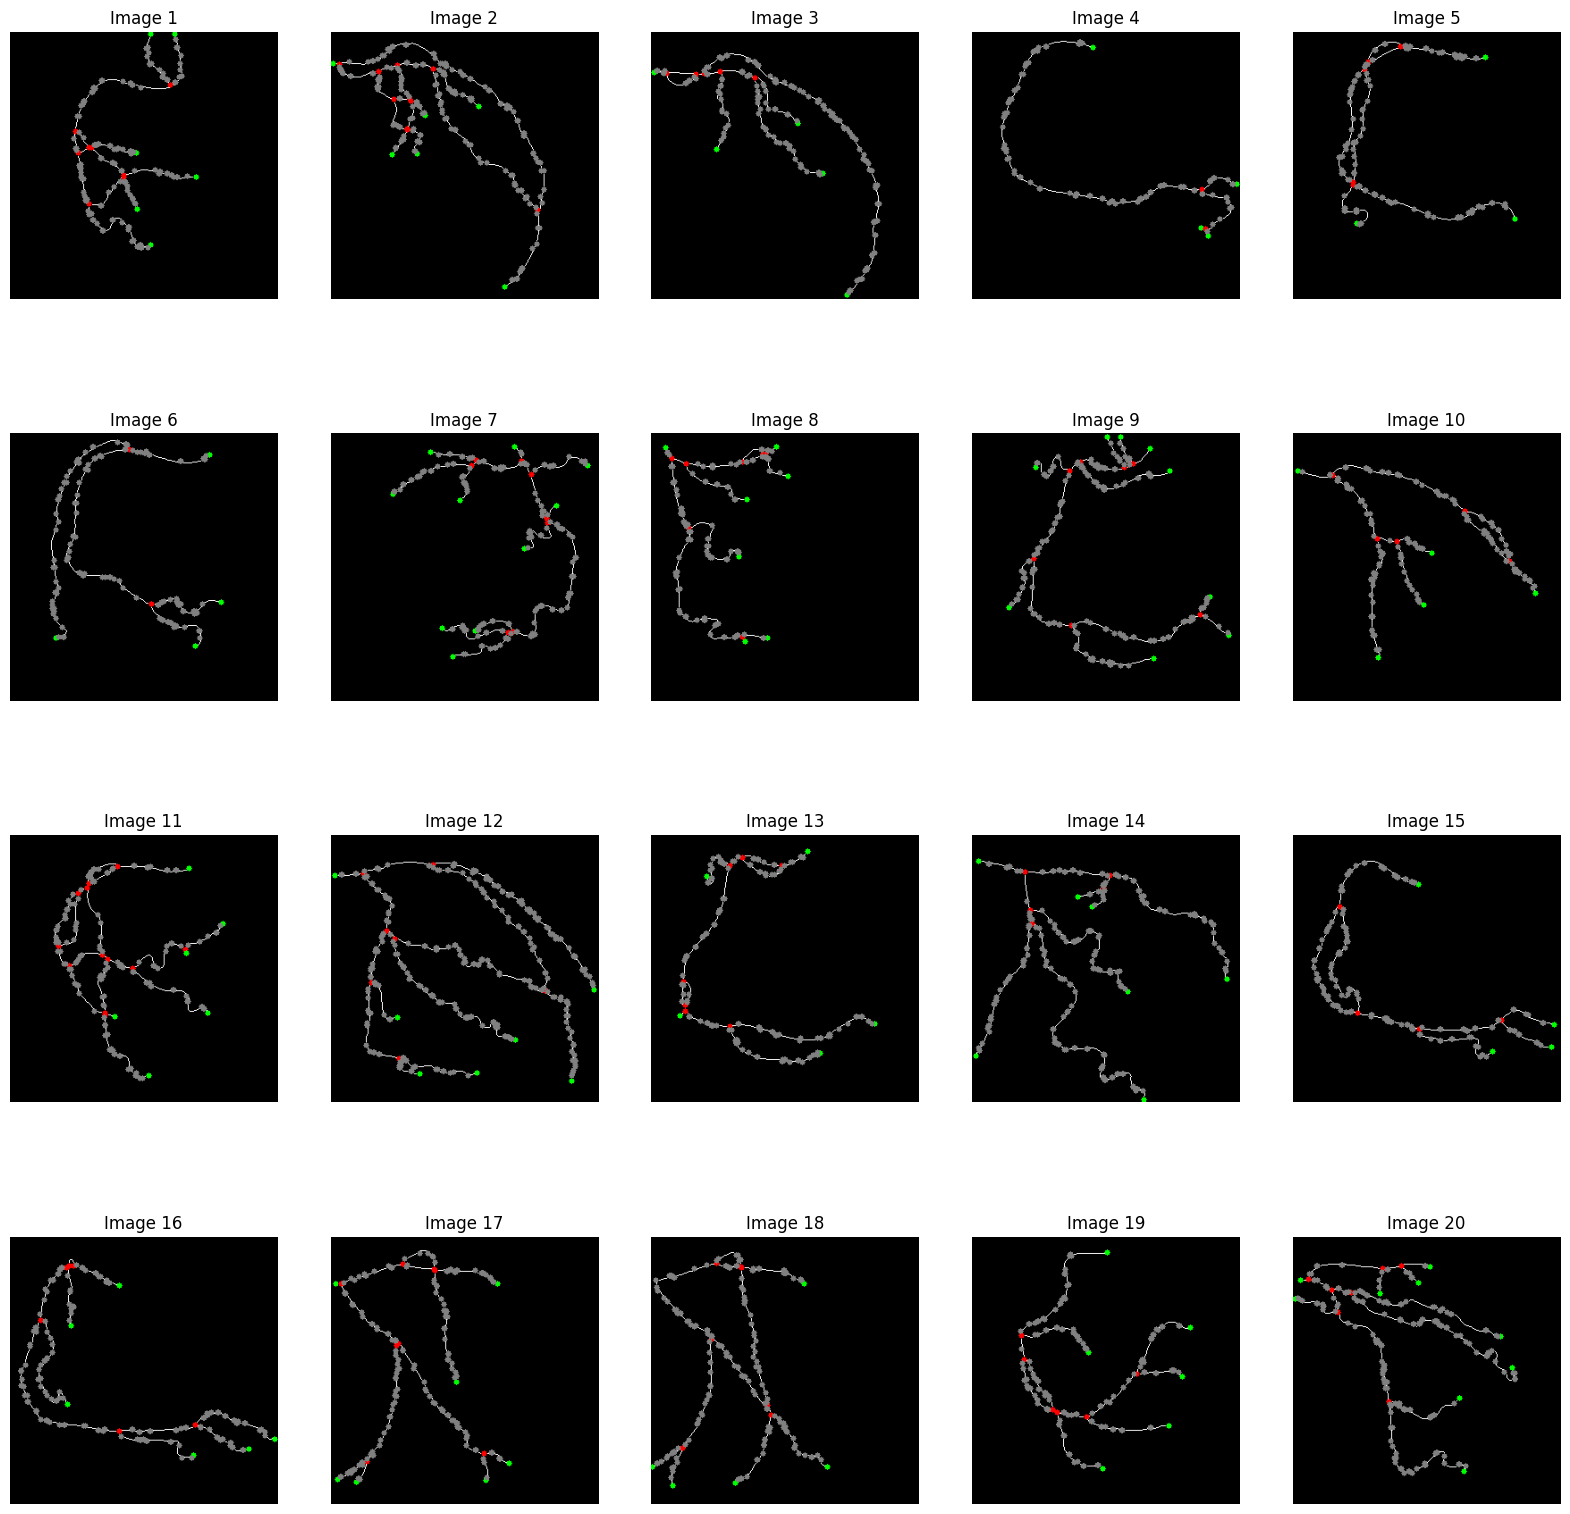

In [11]:
plt.figure(figsize=(20, 20))
for i, image in enumerate(images):
    skeleton = skeletonize(image)
    
    nodes, endpoints, bifurcations, trifurcations = set_nodes(skeleton)  
        
    skeleton = skeleton.astype(np.uint8) * 255
    skeleton = cv.cvtColor(skeleton, cv.COLOR_GRAY2BGR)
    
    for node in nodes:
        cv.circle(skeleton, (node.y, node.x), 3, node.color, -1)
        
    plt.subplot(4, 5, i + 1)
    plt.imshow(skeleton, cmap="gray")
    plt.title("Image {}".format(i + 1)) 
    plt.axis("off")    

### Aristas

In [12]:
def traverse_branch(node, label, labels, skeleton, bifurcations, trifurcations):
    # Recorrer la rama y etiquetar nodos
    stack = [node]
    
    while stack:
        current = stack.pop()
        if current in labels:
            continue
        labels[current] = label
        
        if isinstance(current, tuple):
            x, y = current
        elif hasattr(current, 'x') and hasattr(current, 'y'):
            x, y = current.x, current.y 
            
        neighbors = [(x + dx, y + dy) for dx, dy in [
            (-1, 0), (1, 0), (0, -1), (0, 1),
            (-1, -1), (-1, 1), (1, -1), (1, 1)
        ] if skeleton[x + dx, y + dy] > 0]

        for neighbor in neighbors:
            if neighbor not in labels and neighbor not in bifurcations and neighbor not in trifurcations:
                stack.append(neighbor)
                
    return labels

In [13]:
def label_branches(skeleton, endpoints, bifurcations, trifurcations): 
    labels = {}
    branch_counter = 1

    for endpoint in endpoints:
        if endpoint not in labels:
            traverse_branch(endpoint, branch_counter, labels, skeleton, bifurcations, trifurcations)
            branch_counter += 1
    
    for node in bifurcations + trifurcations:
        labels[node] = "junction"
    
    return labels

In [14]:
def add_valid_transitions(G, graph_labels):
    # Modificar la lógica de conexiones para respetar las ramas
    for node, label in graph_labels.items():
        if isinstance(node, tuple):
            x, y = node
        elif hasattr(node, 'x') and hasattr(node, 'y'):
            x, y = node.x, node.y 

        neighbors = [(x + dx, y + dy) for dx, dy in [
            (-1, 0), (1, 0), (0, -1), (0, 1),
            (-1, -1), (-1, 1), (1, -1), (1, 1)
        ] if (x + dx, y + dy) in graph_labels]

        for neighbor in neighbors:
            if graph_labels[neighbor] == label or graph_labels[node] == "junction":
                G.add_edge(node, neighbor)
                
    return G

In [15]:
def save_graph(G, nodes, endpoints, bifurcations, trifurcations, filename):   
    
    aristas = []
    
    for node1, node2 in G.edges():
        if isinstance(node1, tuple) and isinstance(node2, tuple):
            aristas.append(((node1[1], node1[0]), (node2[1], node2[0])))
        elif hasattr(node1, 'x') and hasattr(node1, 'y') and hasattr(node2, 'x') and hasattr(node2, 'y'):
            aristas.append(((node1.y, node1.x), (node2.y, node2.x)))
    
    json_data = {
        "nodos": [(node.x, node.y) for node in nodes],
        "extremos": [(node.x, node.y) for node in endpoints],
        "bifurcaciones": [(node.x, node.y) for node in bifurcations],
        "trifurcaciones": [(node.x, node.y) for node in trifurcations],
        "intermedios": [(node.x, node.y) for node in nodes if node not in endpoints and node not in bifurcations and node not in trifurcations],
        "aristas": aristas
    }
    
    with open(filename, "w") as f:
        json.dump(json_data, f)

In [16]:
def save_image(image, image_number):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(plt.imread("data/groundtruth/{}_gt.pgm".format(image_number)), cmap="gray")
    plt.axis("off")
    
    plt.savefig("discretization/{}.png".format(image_number))

C:\Users\TheKi\AppData\Local\Temp\ipykernel_30888\3661671732.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 10))


<Figure size 2000x2000 with 0 Axes>

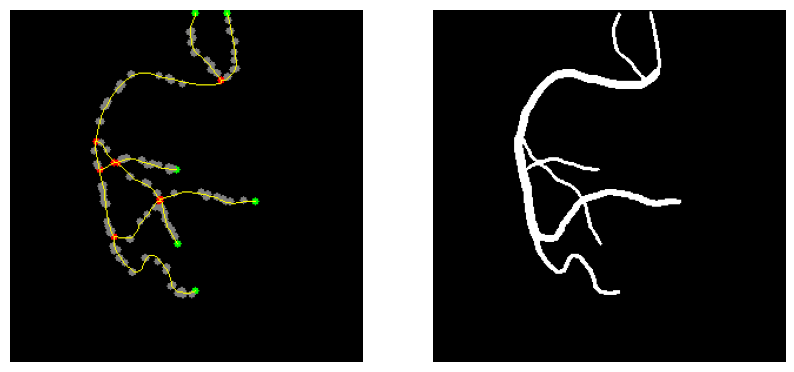

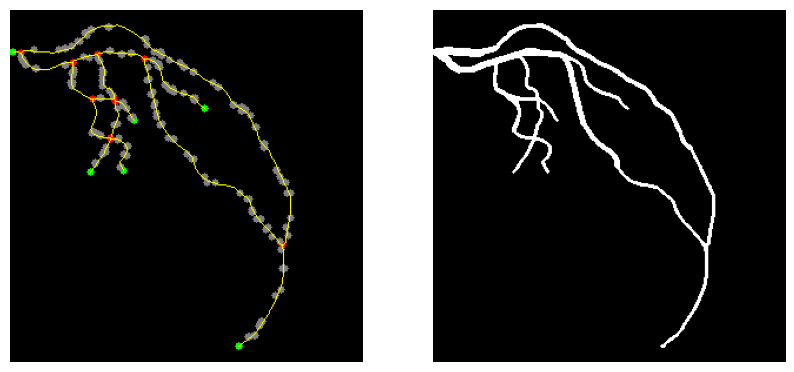

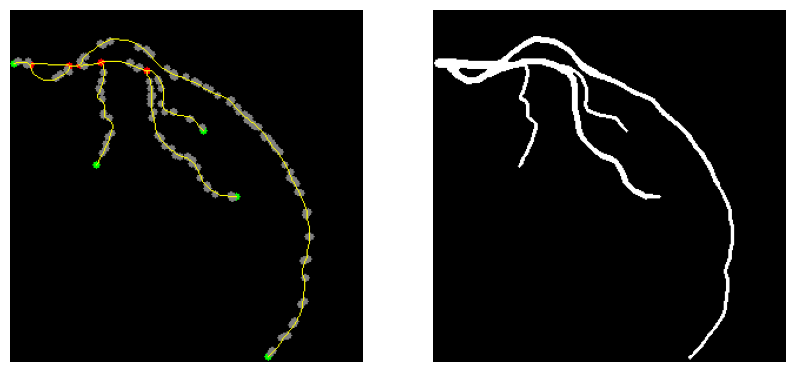

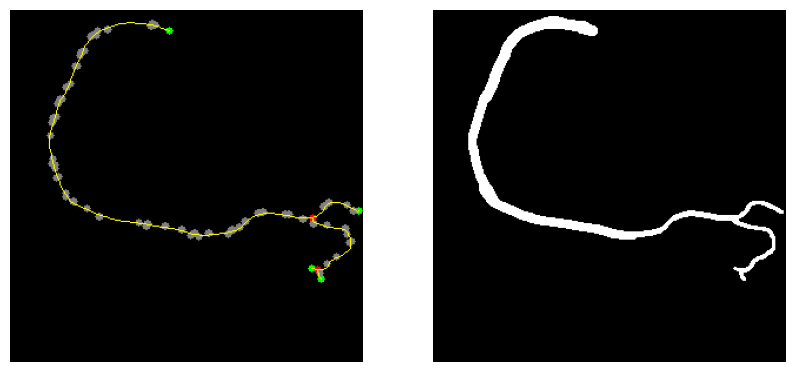

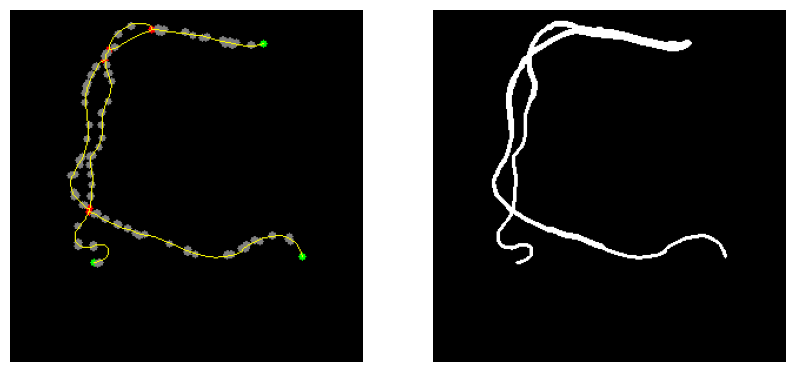

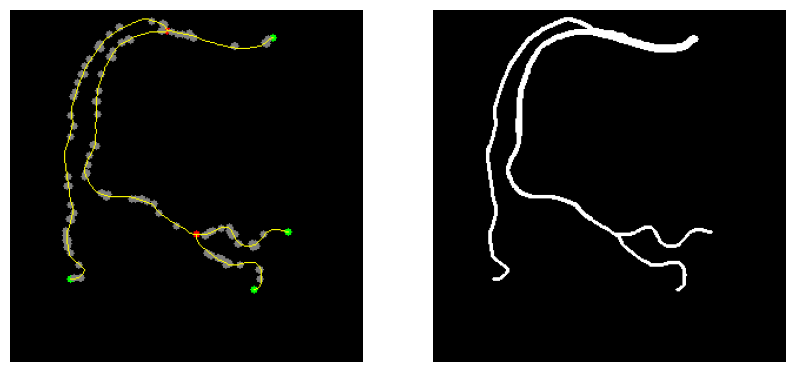

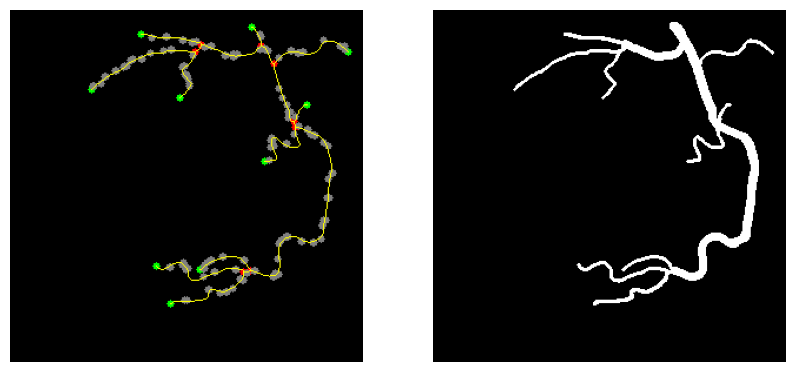

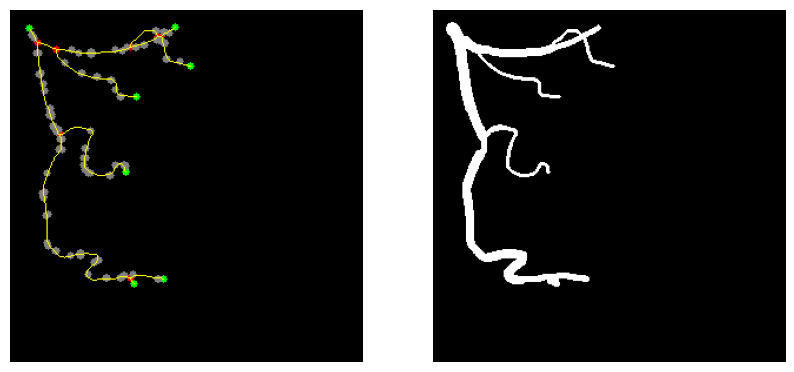

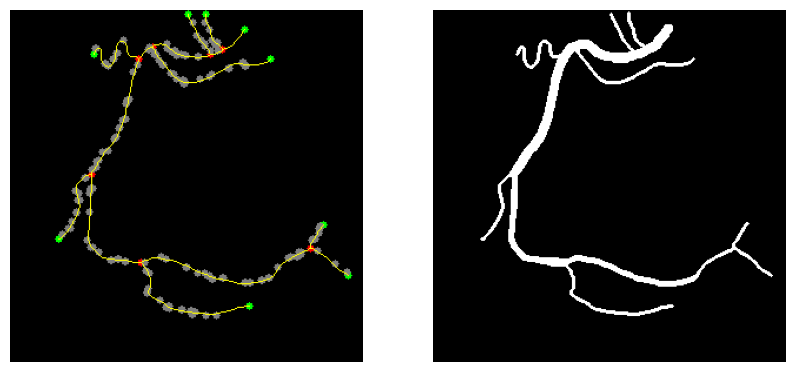

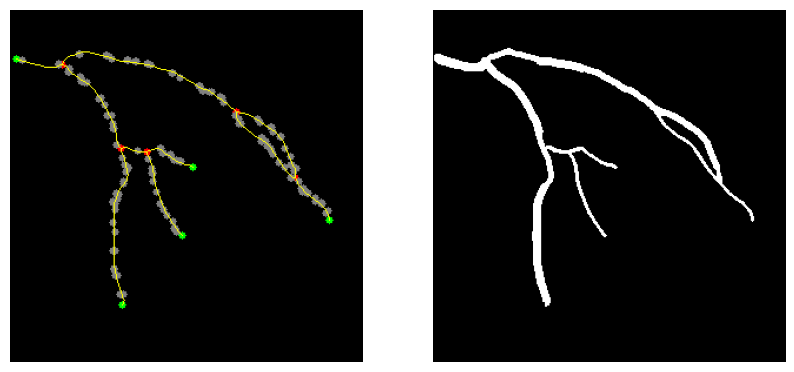

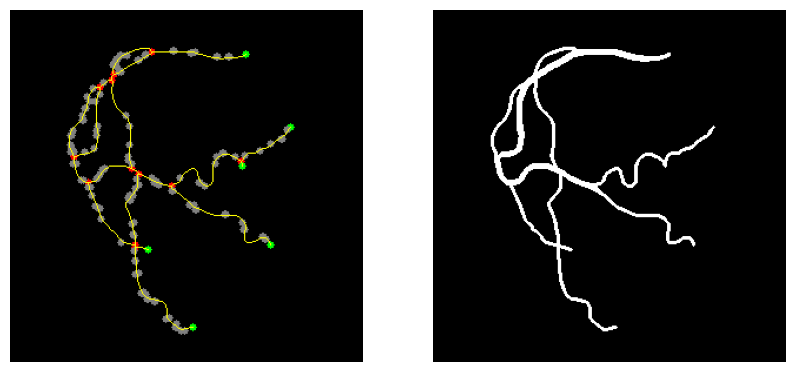

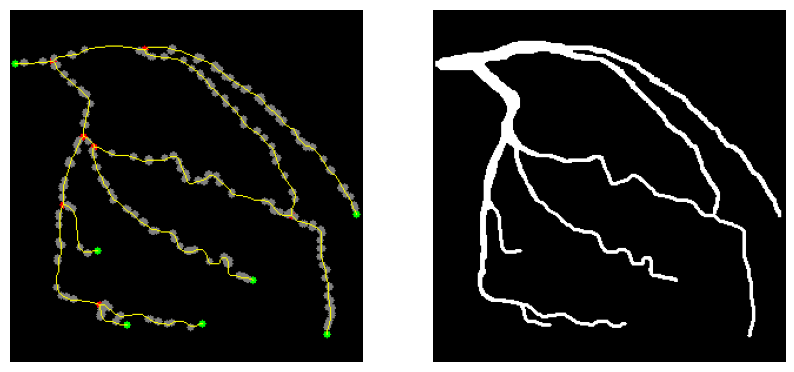

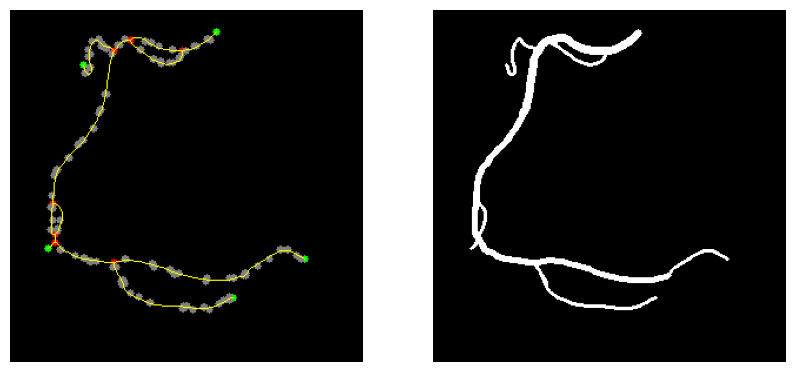

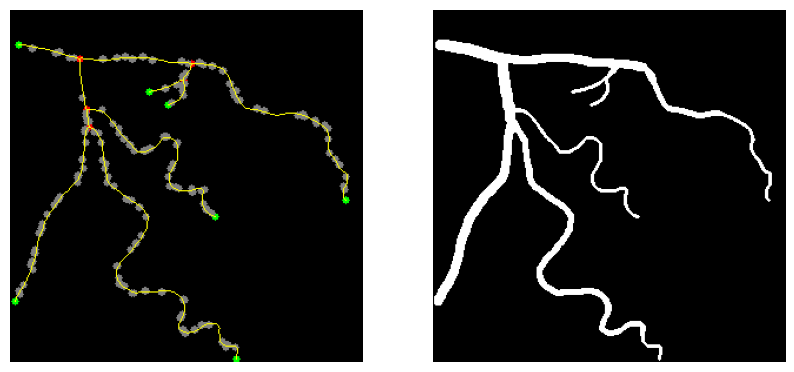

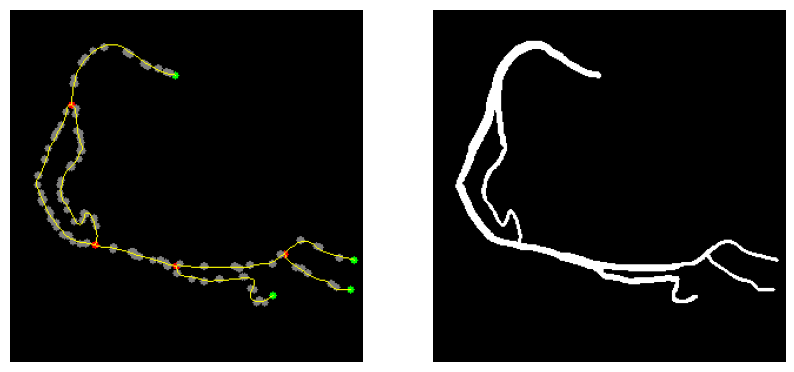

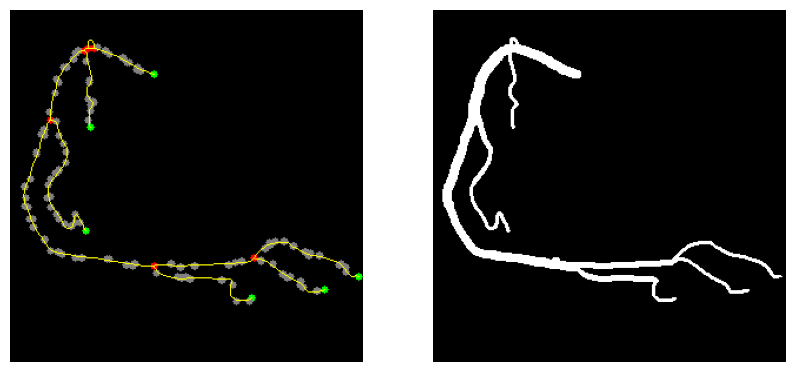

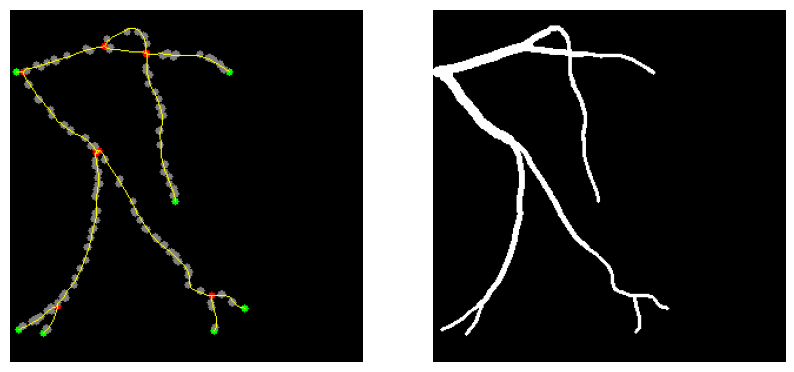

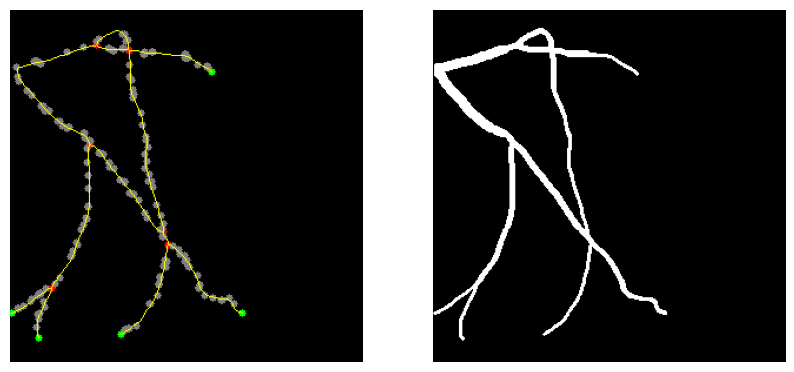

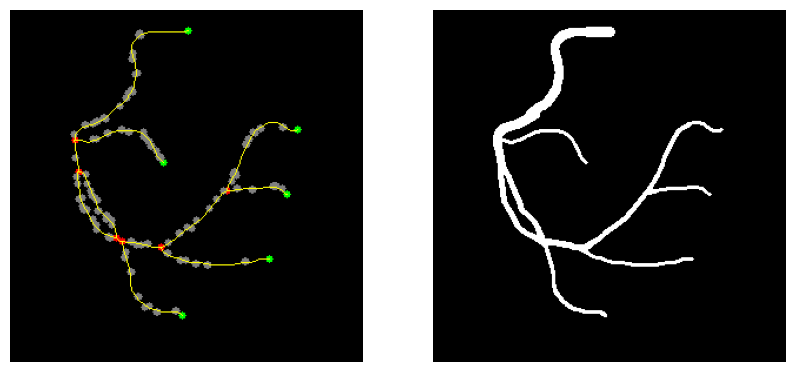

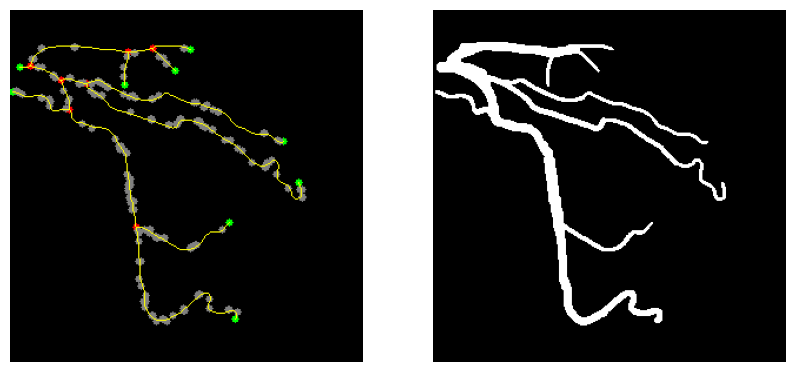

In [17]:
plt.figure(figsize=(20, 20))
for i, image in enumerate(images):
    G = nx.Graph()
    
    skeleton = skeletonize(image)
    
    nodes, endpoints, bifurcations, trifurcations = set_nodes(skeleton) 
    
    labels = label_branches(skeleton, endpoints, bifurcations, trifurcations)
    G = add_valid_transitions(G, labels)
        
    skeleton = skeleton.astype(np.uint8) * 255
    skeleton = cv.cvtColor(skeleton, cv.COLOR_GRAY2BGR)
    
    for node in nodes:
        cv.circle(skeleton, (node.y, node.x), 3, node.color, -1)
        
    for node1, node2 in G.edges:
        if isinstance(node1, tuple) and isinstance(node2, tuple):
            cv.line(skeleton, (node1[1], node1[0]), (node2[1], node2[0]), (255, 255, 0), 1)
        elif hasattr(node1, 'x') and hasattr(node1, 'y') and hasattr(node2, 'x') and hasattr(node2, 'y'):
            cv.line(skeleton, (node1.y, node1.x), (node2.y, node2.x), (255, 255, 0), 1)
            
    save_graph(G, nodes, endpoints, bifurcations, trifurcations, "discretization/{}.json".format(i + 1))
    save_image(skeleton, i + 1)